# ECO REMOVAL

## Authors:
#### * Cortada Garcia, Martí
#### * Gadea Alcaide, Tomàs
#### * Matas Albiol, Pau
#### * Poch Soler, Jofre

### Setup:

In [1]:
# numerical
import scipy.io
import scipy.signal
from scipy.signal import convolve, correlate, argrelextrema
import numpy as np
# plotting
import matplotlib.pyplot as plt
%matplotlib notebook
# sound modules
import sounddevice as sd
from scipy.io import wavfile
# warnings
import warnings
warnings.filterwarnings('ignore')  # shut warnings

### Auxiliar functions:

In [6]:
# In case we use auxiliary functions...

### Loading files:

In [ ]:
import wave
ifile = wave.open("eco4.wav")
samples = ifile.getnframes()
audio = ifile.readframes(samples)

# Convert buffer to float32 using NumPy                                                                                 
audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

# Normalise float32 array so that values are between -1.0 and +1.0                                                      
max_int16 = 2**15
audio_normalised = audio_as_np_float32 / max_int16

def rescale(signal, factor=6, interpolate=False):
    dom = len(signal)
    if not interpolate:
        new = np.zeros(dom*factor)
        for idx, val in enumerate(signal):
            new[idx*factor] = val
        return new
    # with interpolation:
    return np.interp(np.linspace(0, dom, factor*dom+1), np.arange(dom), signal)

wav = rescale(audio_normalised, 2, True)

sd.play(wav)

### Brief introduction: System modeling

We have a signal with echo, let's denote it by $y(t)$, which is the result of recording a signal $x(t)$ (also called _directa_ ) plus another signal produced by reflecting this signal in a point of the room, which arrives at the microphone a bit delayed and attenuated than _directa_ as the path till reach the microphone is larger. 
The output can be modeled as the output of a LTI system, whose input is $x(t)$:
$$y(t)=x(t)+\alpha x(t-T)$$
where:
* $\alpha$ is the attenuation, ($0<\alpha <1$)
* $T$ is the echo delay

We sample the signal with a frequency $f_s$ and obtein:
$$y[n]=x[n]+\alpha x[n-N]$$
where we will suppose $N=Tf_s\in\mathbb{Z}$, for simplicity. 

# Cancelator

## Question a)

We know that the input-output equation corresponts to a LTI system. So, if we can deduce its impulse response $h_1[n]$:
$$\boxed{h_1[n]=\delta[n]+\alpha\delta[n-N]}$$
We can prove it:
As it is a LTI system, we can compute the output:
$$\begin{align}
y[n]&=x[n]*h_1[n]=x[n]*(\delta[n]+\alpha\delta[n-N])=\text{\{apply distributive property of convolution\}}\\
    &=x[n]*\delta[n]+x[n]*\alpha\delta[n-N]=x[n]+\alpha x[n-N]\\
\end{align}$$
Let's see the plot of $h_1[n]$:

<IPython.core.display.Javascript object>


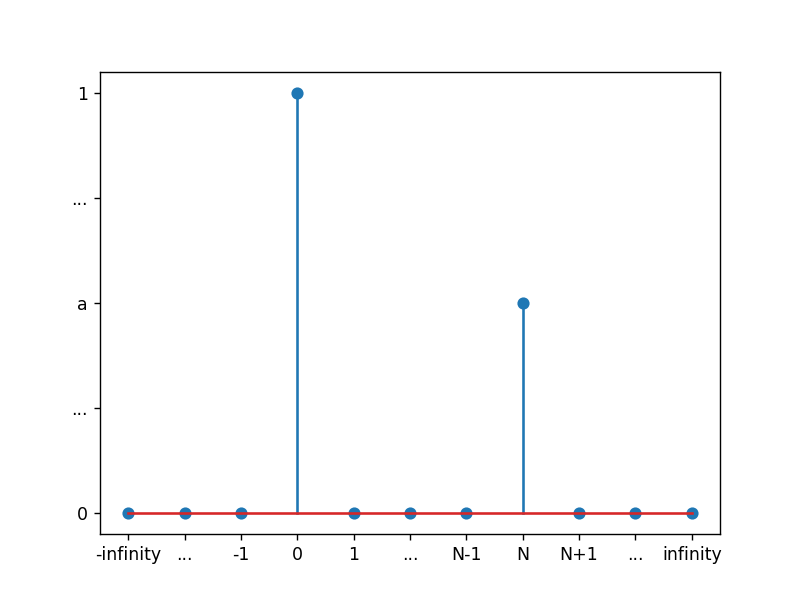

<StemContainer object of 3 artists>

In [5]:
plt.close('all')
xaxis = ['-infinity','...','-1','0','1','...','N-1','N','N+1','...','infinity']
plt.xticks(range(-4,7), xaxis)
yaxis = ['0','...','a','...','1','...']
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0, 1.25], yaxis)
deltas = np.array([0,0,0,1,0,0,0,0.5,0,0,0])
plt.stem(range(-4,7), deltas)

## Question b)

Now, we should use the following system in order to cancel the echo, characterized by the equation:
$$z[n]=y[n]-\beta z[n-N]$$
and we would like to find the impulse response $h_2[n]$:

We see that this equation has a **recursive part**: the output signal can be interpreted as a linear combination of the input signal and delayed copies of the output signal itself. 
* $N$ is the delay in which echo arrives, always non-negative since the path is larger that the direct path. So: $N\geq0$

This case can be solved using finite difference equations (EDFs). We will suppose that initial conditions are nul: $z[-1]=z[-2]=...=z[-N]=0$. In order to find the impulse response $h_2[n]$ we will put in the input signal $y[n]=\delta[n]$. So, let's proceed giving some values:

$$h[0]=\delta[0]-\beta h[-N]=1 \hspace{1cm} \text{(recall that IC are nul)}$$
$$h[1]=\delta[1]-\beta h[1-N]=0$$
$$...=0$$
$$h[N]=\delta[N]-\beta h[N-N]=0-\beta$$
$$...=0$$
$$h[2N]=\delta[2N]-\beta h[2N-N]=0+\beta^2$$
$$...=0$$
$$h[kN]=\delta[kN]-\beta h[kN-N]=0+(-\beta)^k$$
$$...$$
$$\text{so we can deduce the impulse response:}$$
$$\downarrow$$
$$\boxed{h_2[n]=\sum_{k=0}^{\infty}(-\beta)^k\delta[n-kN]}$$

## Question c)

Now, we would like to find which equation should $h_1[n]$ and $h_2[n]$ follow in order to get the following equality $z[n]=x[n]$, that is, to cancel the echo completely.

We will use the following properties to develop our reasoning in the following sections:
* $\delta[n]*x[n]=x[n]$
* $\delta[n]*\delta[n-N]=\delta[n-N]$
* $\delta[n-N_1]*\delta[n-N_2]=\delta[n-N_1-N_2]$
* important to take into account the results we got from the previous sections: 
$$y[n]=x[n]*h_1[n],\hspace{0.3cm}z[n]=y[n]*h_2[n],\hspace{0.3cm}h_1[n]=\delta[n]+\alpha\delta[n-N],\hspace{0.3cm}h_2[n]=\sum_{k=0}^{\infty}(-\beta)^k\delta[n-kN]$$

$$\begin{align}
z[n]&=y[n]*h_2[n]=\text{\{by definition of }y[n]\}\\
    &=x[n]*h_1[n]*h_2[n]
\end{align}$$

So, if we want $z[n]=x[n]$, then, $h_1[n]*h_2[n]=\delta[n]$ ($\delta$ has to behave as identity). Therefore, we conclude:
$$\boxed{z[n]=x[n]\hspace{0.4cm}\text{iff}\hspace{0.4cm} h_1[n]*h_2[n]=\delta[n]}$$

So, in the following question we will develop this condition in order to fin $\beta$ as a function of $\alpha$.

## Question d)

Now, we want to calculate $\beta$ as a function of $\alpha$ to cancel the echo. Let's try to develop $h_1[n]*h_2[n]$ and prove we get $\delta[n]$ as a result.

$$\begin{align}
h_1[n]*h_2[n]&=(\delta[n]+\alpha\delta[n-N])*(\sum_{k=0}^{\infty}(-\beta)^k\delta[n-kN])=\text{\{apply distributive property of convolution\}}\\
             &=\sum_{k=0}^{\infty}(-\beta)^k\delta[n-kN])+\alpha(\sum_{k=0}^{\infty}(-\beta)^k\delta[n-(i+1)N])=\text{\{and develop the sumations\}}\\
             &=\delta[n]\boxed{-\beta\delta[n-N]+\beta^2\delta[n-2N]-\beta^3\delta[n-3N]+...+}\\
             &=\hspace{0.8cm}\boxed{+\alpha\delta[n-N]-\alpha\beta\delta[n-2N]+\alpha\beta^2\delta[n-3N]-...}\\
\end{align}$$

and we can check that **if $\boxed{\alpha=\beta}$, both boxed parts will cancel and will remain $\delta[n]$, which was what we wanted to demonstrate!**
$$Q.E.D$$

# Echo parameter estimation

## Question e)

We are asked to check that $R_{yy}[m]=(1+\alpha^2)R_{xx}[m]+\alpha R_{xx}[m-N]+\alpha R_{xx}[m+N]$. To do so, we will apply the autocorrelation definition (reminding that $y[n]=x[n]+\alpha x[n-N]$ and the importance of change of variables ( _variables mudas_ )).
$$\begin{align}
R_{yy}[m]&=\sum_{n=-\infty}^{\infty} y[n+m]y^*[n]=\text{\{by definition of }y[n]\text{\}}\\
         &=\sum_{n=-\infty}^{\infty} ((x[n+m]+\alpha x[n+m-N])·(x^*[n]+\alpha x^*[n-N]))
\end{align}$$

and developing the products we obtain:
* $\sum_{n=-\infty}^{\infty} (x[n+m]x*[n])=R_{xx}[m]$
* $\sum_{n=-\infty}^{\infty} (x[n+m]\alpha x^*[n-N])=\text{\{let }k=n-N\}=\alpha\sum_{k=-\infty}^{\infty}x[k+N+m]x^*[k]=\alpha R_{xx}[m+N]$
* $\sum_{n=-\infty}^{\infty}\alpha x[n+m-N]x^*[n]=\alpha R_{xx}[m-N]$
* $\sum_{n=-\infty}^{\infty}\alpha^2x[n+m-N]x^*[n-N]=\text{\{let }k=n-N\}=\alpha^2\sum_{k=-\infty}^{\infty}x[k+m]x^*[k]=\alpha^2R_{xx}[m]$

where adding the past results we obtain what we wanted to demonstrate:
$$\begin{align}
\boxed{R_{yy}[m]}&=R_{xx}[m]+\alpha R_{xx}[m+N]+\alpha R_{xx}[m-N]+\alpha^2R_{xx}[m]=\text{\{simplifying\}}\\
                 &=\boxed{(1+\alpha^2)R_{xx}[m]+\alpha R_{xx}[m-N]+\alpha R_{xx}[m+N]}
\end{align}$$

$$\quad Q.E.D.$$

## Question f)

Now, we want to find which equations we should solve in order to find $\alpha$ and $N$ from $R_{yy}[m]$.
We will take into account:
* $0<\alpha <1$
* $R_{xx}[N]<<R_{xx}[0]$
* In this case, $R_{xx}[m]$ will have maximums in $m=0$ and $m=\pm N$.

We will make some aproximations considering the past properties in the equation $R_{yy}[m]=(1+\alpha^2)R_{xx}[m]+\alpha R_{xx}[m-N]+\alpha R_{xx}[m+N]$:
* $R_{yy}[-N]=\alpha R_{xx}[0]\hspace{16cm}$ (i) 
* $R_{yy}[0]=(1+\alpha^2)R_{xx}[0]\hspace{15.2cm}$ (ii)
* $R_{yy}[N]=\alpha R_{xx}[0]\hspace{16.4cm}$ (iii)

Dividing (ii)/(iii) we get:
$$\frac{R_{yy}[0]}{R_{yy}[N]}=\frac{(1+\alpha^2)}{\alpha}$$
we will isolate $\alpha$ and from the two possible solutions we will get the one that $\alpha <1$. For simplicity, let's call $\lambda=\frac{R_{yy}[0]}{R_{yy}[N]}$ and solve:
$$\alpha\lambda=1+\alpha^2\to\alpha^2-\lambda\alpha+1=0$$
$$\alpha=\frac{\lambda\pm\sqrt{\lambda^2-4}}{2}$$
so we can write:
$$(\alpha-\frac{\lambda+\sqrt{\lambda^2-4}}{2})(\alpha-\frac{\lambda-\sqrt{\lambda^2-4}}{2})=0$$
and we know that **the multiplication of the roots is the independent term** and $\lambda=\frac{R_{yy}[0]}{R_{yy}[N]}>2$ (because it has a real solution iff $\lambda\geq 2$, but $\lambda\neq 2$ since $\alpha$ would be 1 and it is defined $\in(0,1)$), so as the roots can not be equal to 1:
* $(\frac{\lambda+\sqrt{\lambda^2-4}}{2})>1$
* $(\frac{\lambda-\sqrt{\lambda^2-4}}{2})<1$

and we wanted the solution $<1$, therefore:
$$\begin{align}
\boxed{\alpha}&=\frac{\lambda-\sqrt{\lambda^2-4}}{2}=\{\lambda=\frac{R_{yy}[0]}{R_{yy}[N]}\}\\
      &=\boxed{\frac{\frac{R_{yy}[0]}{R_{yy}[N]}-\sqrt{(\frac{R_{yy}[0]}{R_{yy}[N]})^2-4}}{2}}
\end{align}$$

# Application of a real case

## Question g)

## Question h)